# 2.2 Datasetの実装、 2.3 DataLoaderの実装

本ファイルでは、SSDなど物体検出アルゴリズム用のDatasetとDataLoaderを作成します。

VOC2012データセットを対象とします。


# 2.2 学習目標

1.	物体検出で使用するDatasetクラスを作成できるようになる
2.	SSDの学習時のデータオーギュメンテーションで、何をしているのかを理解する



# 2.3 学習目標

1.	物体検出で使用するDataLoaderクラスを作成できるようになる



# 事前準備


OpenCVのインストール

- pip install opencv-python

本書の指示に従い、VOC2010のデータセットをダウンロード

- http://host.robots.ox.ac.uk/pascal/VOC/voc2012/



In [1]:
# パッケージのimport
import os.path as osp
import random
# XMLをファイルやテキストから読み込んだり、加工したり、保存したりするためのライブラリ
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [2]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# 画像データ、アノテーションデータへのファイルパスのリストを作成する

In [3]:
# 学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する


def make_datapath_list(rootpath):
    """
    データへのパスを格納したリストを作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    """

    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        train_img_list.append(img_path)  # リストに追加
        train_anno_list.append(anno_path)  # リストに追加

    # 検証データの画像ファイルとアノテーションファイルへのパスリストを作成
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        val_img_list.append(img_path)  # リストに追加
        val_anno_list.append(anno_path)  # リストに追加

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [4]:
# ファイルパスのリストを作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# 動作確認
print(train_img_list[0])


./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


# xml形式のアノテーションデータをリストに変換する

In [5]:
# 「XML形式のアノテーション」を、リスト形式に変換するクラス


class Anno_xml2list(object):
    """
    1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

    Attributes
    ----------
    classes : リスト
        VOCのクラス名を格納したリスト
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        1枚の画像に対する「XML形式のアノテーションデータ」を、画像サイズで規格化してからリスト形式に変換する。

        Parameters
        ----------
        xml_path : str
            xmlファイルへのパス。
        width : int
            対象画像の幅。
        height : int
            対象画像の高さ。

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            物体のアノテーションデータを格納したリスト。画像内に存在する物体数分のだけ要素を持つ。
        """

        # 画像内の全ての物体のアノテーションをこのリストに格納します
        ret = []

        # xmlファイルを読み込む
        xml = ET.parse(xml_path).getroot()

        # 画像内にある物体（object）の数だけループする
        for obj in xml.iter('object'):

            # アノテーションで検知がdifficultに設定されているものは除外
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 1つの物体に対するアノテーションを格納するリスト
            bndbox = []

            name = obj.find('name').text.lower().strip()  # 物体名
            bbox = obj.find('bndbox')  # バウンディングボックスの情報

            # アノテーションの xmin, ymin, xmax, ymaxを取得し、0～1に規格化
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOCは原点が(1,1)なので1を引き算して（0, 0）に
                cur_pixel = int(bbox.find(pt).text) - 1

                # 幅、高さで規格化
                if pt == 'xmin' or pt == 'xmax':  # x方向のときは幅で割算
                    cur_pixel /= width
                else:  # y方向のときは高さで割算
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # アノテーションのクラス名のindexを取得して追加
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # resに[xmin, ymin, xmax, ymax, label_ind]を足す
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]


In [6]:
# 動作確認　
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 画像の読み込み OpenCVを使用
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# アノテーションをリストで表示
transform_anno(val_anno_list[ind], width, height)


array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

# 画像とアノテーションの前処理を行うクラスDataTransformを作成する

In [7]:
# フォルダ「utils」にあるdata_augumentation.pyからimport。
# 入力画像の前処理をするクラス
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans


class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練と推論で異なる動作をする。
    画像のサイズを300x300にする。
    学習時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (B, G, R)
        各色チャネルの平均値。
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # intをfloat32に変換
                ToAbsoluteCoords(),  # アノテーションデータの規格化を戻す
                PhotometricDistort(),  # 画像の色調などをランダムに変化
                Expand(color_mean),  # 画像のキャンバスを広げる
                RandomSampleCrop(),  # 画像内の部分をランダムに抜き出す
                RandomMirror(),  # 画像を反転させる
                ToPercentCoords(),  # アノテーションデータを0-1に規格化
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ]),
            'val': Compose([
                ConvertFromInts(),  # intをfloatに変換
                Resize(input_size),  # 画像サイズをinput_size×input_sizeに変形
                SubtractMeans(color_mean)  # BGRの色の平均値を引き算
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, boxes, labels)


/Users/shotashimizu/github.com/banbiossa/pytorch_advanced/.venv/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


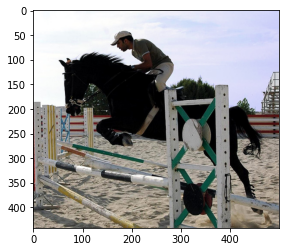

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


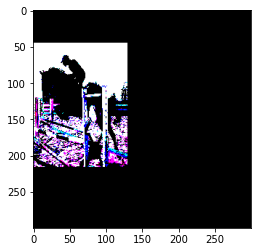

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0.02978339 0.26126126 0.40703971 0.68983269]
 [0.12454874 0.20592021 0.24277978 0.36422136]]


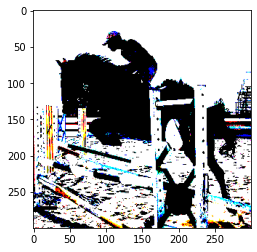

[[ 52.  86. 470. 419.]
 [157.  43. 288. 166.]]


In [9]:
# 動作の確認

# 1. 画像読み込み
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
height, width, channels = img.shape  # 画像のサイズを取得

# 2. アノテーションをリストに
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 前処理クラスの作成
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする
transform = DataTransform(input_size, color_mean)

# 5. train画像の表示
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()
print(boxes)


# 6. val画像の表示
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()
print(boxes)


# Datasetを作成する

In [9]:
# VOC2012のDatasetを作成する


class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    transform_anno : object
        xmlのアノテーションをリストに変換するインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train もしくは valを指定
        self.transform = transform  # 画像の変形
        self.transform_anno = transform_anno  # アノテーションデータをxmlからリストへ

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のテンソル形式のデータとアノテーションを取得
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''前処理をした画像のテンソル形式のデータ、アノテーション、画像の高さ、幅を取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [高さ][幅][色BGR]
        height, width, channels = img.shape  # 画像のサイズを取得

        # 2. xml形式のアノテーション情報をリストに
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 前処理を実施
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 色チャネルの順番がBGRになっているので、RGBに順番変更
        # さらに（高さ、幅、色チャネル）の順を（色チャネル、高さ、幅）に変換
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBoxとラベルをセットにしたnp.arrayを作成、変数名「gt」はground truth（答え）の略称
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width


In [10]:
# 動作確認
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# データの取り出し例
val_dataset.__getitem__(1)


(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9082,  -13.2200,
             -9.4034],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9501,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2816,  -20.1750,   -5.5633,  ..., -104.9934, -111.8350,
           -119.0000],
          [ -20.4766,  -21.0000,  -12.6334,  ..., -107.1685, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0766,  -14.7250,
            -11.8534],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5016,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9501,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

# DataLoaderを作成する

In [11]:
def od_collate_fn(batch):
    """
    Datasetから取り出すアノテーションデータのサイズが画像ごとに異なります。
    画像内の物体数が2個であれば(2, 5)というサイズですが、3個であれば（3, 5）など変化します。
    この変化に対応したDataLoaderを作成するために、
    カスタイマイズした、collate_fnを作成します。
    collate_fnは、PyTorchでリストからmini-batchを作成する関数です。
    ミニバッチ分の画像が並んでいるリスト変数batchに、
    ミニバッチ番号を指定する次元を先頭に1つ追加して、リストの形を変形します。
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0] は画像imgです
        targets.append(torch.FloatTensor(sample[1]))  # sample[1] はアノテーションgtです

    # imgsはミニバッチサイズのリストになっています
    # リストの要素はtorch.Size([3, 300, 300])です。
    # このリストをtorch.Size([batch_num, 3, 300, 300])のテンソルに変換します
    imgs = torch.stack(imgs, dim=0)

    # targetsはアノテーションデータの正解であるgtのリストです。
    # リストのサイズはミニバッチサイズです。
    # リストtargetsの要素は [n, 5] となっています。
    # nは画像ごとに異なり、画像内にある物体の数となります。
    # 5は [xmin, ymin, xmax, ymax, class_index] です

    return imgs, targets


In [12]:
# データローダーの作成

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
images, targets = next(batch_iterator)  # 1番目の要素を取り出す
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size())  # ミニバッチのサイズのリスト、各要素は[n, 5]、nは物体数


torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [13]:
print(train_dataset.__len__())
print(val_dataset.__len__())


5717
5823


以上